In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 26.2 MB/s 
     |████████████████████████████████| 4.7 MB 58.3 MB/s 
     |████████████████████████████████| 365 kB 9.1 MB/s 
     |████████████████████████████████| 1.3 MB 45.0 MB/s 
     |████████████████████████████████| 212 kB 7.3 MB/s 
     |████████████████████████████████| 120 kB 54.2 MB/s 
     |████████████████████████████████| 115 kB 12.6 MB/s 
     |████████████████████████████████| 127 kB 48.1 MB/s 
     |████████████████████████████████| 6.6 MB 37.5 MB/s 
Mounted at /content/gdrive


In [2]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 23.5 MB/s 


In [3]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *
from numpy.linalg import norm
import pickle5 as pickle

## Load Data


*   Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}

*   Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive}




In [15]:
filename01 = os.getcwd() + '/gdrive/MyDrive/data/one_dataset/ppl_instance_pred01.csv'
data_df01 = pd.read_csv(filename01)

filename14 = os.getcwd() + '/gdrive/MyDrive/data/one_dataset/ppl_instance_pred14.csv'
data_df14 = pd.read_csv(filename14)

len(list(data_df01['pipelines'].unique())), len(list(data_df14['pipelines'].unique()))

(31, 31)

## Construct DataLoader
Split the data into Training and Testing dataset

In [18]:
test_frac = 0.1 # train : test = 9:1

In [19]:
test_df01 = data_df01.sample(frac = test_frac)
train_df01 = data_df01.drop(test_df01.index)
train_df01.shape, test_df01.shape

test_df14 = data_df14.sample(frac = test_frac)
train_df14 = data_df14.drop(test_df14.index)
train_df14.shape, test_df14.shape

((36967, 3), (4108, 3))

In [20]:
# columns=['pipelines', 'instanceIDs', 'predictions']
dls01 = CollabDataLoaders.from_df(train_df01, seed=42, valid_pct=0.2, user_name='pipelines', item_name='instanceIDs', rating_name='predictions', bs=64)
dls01.show_batch()

dls14 = CollabDataLoaders.from_df(train_df14, seed=42, valid_pct=0.2, user_name='pipelines', item_name='instanceIDs', rating_name='predictions', bs=64)
dls14.show_batch()

,pipelines,instanceIDs,predictions
0,"[('nusvc', NuSVC(kernel='poly', nu=0.1, random_state=42, shrinking=False))]",795,0
1,"[('passiveaggressiveclassifier', PassiveAggressiveClassifier(C=0.001, loss='squared_hinge', random_state=42))]",1298,0
2,"[('logisticregression', LogisticRegression(fit_intercept=False, random_state=42))]",369,1
3,"[('perceptron', Perceptron(penalty='l2', random_state=42))]",1214,1
4,"[('adaboostclassifier', AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=10,\n random_state=42))]",1137,0
5,"[('adaboostclassifier', AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42))]",582,0
6,"[('randomforestclassifier', RandomForestClassifier(criterion='entropy', max_features=0.75,\n min_impurity_decrease=0.0005, min_samples_split=10,\n n_estimators=500, random_state=42))]",300,0
7,"[('gaussiannb', GaussianNB())]",482,1
8,"[('gradientboostingclassifier', GradientBoostingClassifier(learning_rate=100.0, loss='exponential',\n max_depth=10, max_features=0.1,\n min_impurity_decrease=0.0005, n_estimators=500,\n random_state=42, subsample=0.05))]",454,0
9,"[('extratreesclassifier', ExtraTreesClassifier(bootstrap=True, max_features=None, min_samples_leaf=15,\n min_samples_split=10, n_estimators=500, random_state=42))]",513,0


,pipelines,instanceIDs,predictions
0,"[('extratreesclassifier', ExtraTreesClassifier(bootstrap=True, criterion='entropy', max_features='log2',\n min_samples_split=10, n_estimators=1000, random_state=42))]",583,3.0
1,"[('bernoullinb', BernoulliNB(alpha=0.1, binarize=0.25, fit_prior=False))]",1189,4.0
2,"[('decisiontreeclassifier', DecisionTreeClassifier(max_depth=15, max_features=0.1,\n min_impurity_decrease=0.003, min_samples_leaf=15,\n min_samples_split=15, random_state=42))]",385,3.0
3,"[('bernoullinb', BernoulliNB(binarize=0.75, fit_prior=False))]",98,4.0
4,"[('gaussiannb', GaussianNB())]",42,3.0
5,"[('ridgeclassifier', RidgeClassifier(alpha=0.0001, random_state=42))]",346,2.0
6,"[('bernoullinb', BernoulliNB(binarize=0.75, fit_prior=False))]",207,1.0
7,"[('perceptron', Perceptron(penalty='l2', random_state=42))]",800,3.0
8,"[('kneighborsclassifier', KNeighborsClassifier(n_neighbors=10, p=1, weights='distance'))]",223,3.0
9,"[('randomforestclassifier', RandomForestClassifier(criterion='entropy', max_features=0.75,\n min_impurity_decrease=0.0005, min_samples_split=10,\n n_estimators=500, random_state=42))]",769,3.0


## Initialize variables

In [21]:
# dls01 / dls14 doesn't matter
n_users  = len(dls01.classes['pipelines'])
n_items = len(dls01.classes['instanceIDs'])
n_factors = 40

In [23]:
filename = os.getcwd() + '/gdrive/MyDrive/data/one_dataset/instance_feature.pickle'
X_features = pickle.load(open(filename, "rb"))

## Model

In [24]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))


class DotProductBias(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.item_factors = create_params([n_items, n_factors])
        self.item_bias = create_params([n_items])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        items = self.item_factors[x[:,1]]
        res = (users*items).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.item_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

## Similarity Term

In [25]:
def CoSimilarity(v1, v2):
  return np.dot(v1, v2)/(norm(v1)*norm(v2))

def EuclideanDis(a, b):
  return np.linalg.norm(a-b)

def nchoose2_comb(n):
  """
  Return a <itertools.combinations> of all nChoose2 index combinations
  """
  idxs = list(range(n))
  comb = itertools.combinations(idxs, 2)
  return list(comb)

In [26]:
# pre-calculate cosin similarity of all combinations of a batch
def get_cosim_vector(comb, matrix):
  res_vec = np.zeros((len(comb),))
  for r, (i, j) in enumerate(comb):
    # instanceID begin from 1!
    res_vec[r] = CoSimilarity(matrix[i-1, :], matrix[j-1, :])
  return res_vec

# helper function for calculating EuclideanDis all combinations of a batch
def get_EuclideanDis_vector(comb, matrix):
  res_vec = np.zeros((len(comb),))
  for r, (i, j) in enumerate(comb):
    # instanceID begin from 1!
    res_vec[r] = np.linalg.norm(matrix[i-1, :] - matrix[j-1, :])
  return res_vec

## My Learner

In [27]:
class MyLearner(Learner):
    @delegates(Learner.__init__)
    def __init__(self,
                 dls,  # `DataLoaders` containing data for each dataset needed for `model`
                 model:callable, #  The model to train or use for inference
                 loss_func:Union[callable, None]=None,  # Loss function for training
                 opt_func=Adam,  # Optimisation function for training
                 lr=defaults.lr,  # Learning rate
                 splitter:callable=trainable_params,  # Used to split parameters into layer groups
                 cbs=None,  # Callbacks
                 metrics=None,  # Printed after each epoch
                 path=None,  # Parent directory to save, load, and export models
                 model_dir='models',  # Subdirectory to save and load models
                 wd=None,  # Weight decay
                 wd_bn_bias=False,  # Apply weight decay to batchnorm bias params?
                 train_bn=True,  # Always train batchnorm layers?
                 moms=(0.95,0.85,0.95),  # Momentum
                 default_cbs:bool=True,  # Include default callbacks?
                 sim_lambda=0.,
                 l1_lambda=0.,
                 l2_lambda=0.,
                 decouple_wd=True,
                 **kwargs
                ):
        super().__init__(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr,
                         splitter=splitter, cbs=cbs, metrics=metrics, path=path, model_dir=model_dir, 
                         wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms, default_cbs=default_cbs, **kwargs)
        self.sim_lambda, self.l1_lambda, self.l2_lambda = sim_lambda, l1_lambda, l2_lambda
        self.decouple_wd = decouple_wd

    ############################ add regularization ############################
    def l1_reg(self):
        user_factors_w1 = self.model.user_factors.abs().sum()
        user_bias_w1 = self.model.user_bias.abs().sum()
        item_factors_w1 = self.model.item_factors.abs().sum()
        item_bias_w1 = self.model.item_bias.abs().sum()
        l1_norm = user_factors_w1 + user_bias_w1 + item_factors_w1 + item_bias_w1
        return self.l1_lambda * l1_norm

    def l2_reg(self):
        user_factors_w2 = self.model.user_factors.pow(2).sum()
        user_bias_w2 = self.model.user_bias.pow(2).sum()
        item_factors_w2 = self.model.item_factors.pow(2).sum()
        item_bias_w2 = self.model.item_bias.pow(2).sum()
        l2_norm = user_factors_w2 + user_bias_w2 + item_factors_w2 + item_bias_w2
        return self.l2_lambda * l2_norm
    
    def sim_term(self, cosim_vec, batch_comb):
        distances = get_EuclideanDis_vector(batch_comb, self.model.item_factors.detach().numpy()) # vector
        sim = 1 + CoSimilarity(cosim_vec, distances)
        return self.sim_lambda * sim
    ############################################################################
    
    def _do_one_batch(self):
        self.pred = self.model(*self.xb)
        self('after_pred')
        if len(self.yb):
            self.loss_grad = self.loss_func(self.pred, *self.yb)
            # self.loss = self.loss_grad.clone()
            # add regularization to loss, limit sim_term to batches
            instance_idxs = self.xb[0][:, 1] # NOTE: ID begins from 1
            batch_comb = list(itertools.combinations(instance_idxs, 2))
            cosim_vec = get_cosim_vector(batch_comb, X_features)
            self.loss = self.loss_grad.clone() + self.sim_term(cosim_vec, batch_comb) + self.l1_reg() + self.l2_reg()
        self('after_loss')
        if not self.training or not len(self.yb): return
        self._with_events(self._backward, 'backward', CancelBackwardException)
        self._with_events(self._step, 'step', CancelStepException)
        self.opt.zero_grad()

## My model train

#### Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}

epoch,train_loss,valid_loss,time
0,1.098643,1.083851,01:04
1,1.067155,1.062659,01:04
2,1.040661,1.052885,01:03
3,1.030150,1.049153,01:04
4,1.022487,1.048369,01:03
5,1.014843,1.048000,01:04
6,1.014913,1.048089,01:04
7,1.010040,1.048636,01:04
8,1.010714,1.049525,01:04
9,1.003408,1.049019,01:05


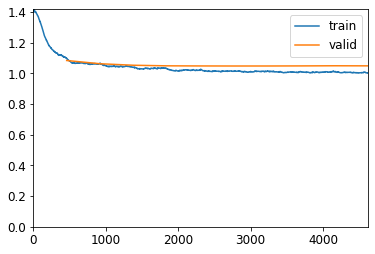

In [28]:
my_model01 = DotProductBias(n_users, n_items, n_factors, y_range=(0,1.5))
learn_wd01 = MyLearner(dls01, my_model01, loss_func=MSELossFlat(), opt_func=Adam, lr=5e-3, cbs=[ShowGraphCallback()], wd=1e-2, sim_lambda=1, l1_lambda=0., l2_lambda=0., decouple_wd=True) # wd, Adam
# Use sgd optimizer use following line
# learn_sgd01 = MyLearner(dls01, my_model01, loss_func=MSELossFlat(), opt_func=SGD, lr=1e-2, cbs=[ShowGraphCallback()], wd=0., sim_lambda=1, l1_lambda=5e-3, l2_lambda=5e-3, decouple_wd=False) # sgd
learn_wd01.fit(10)

#### Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive} 

epoch,train_loss,valid_loss,time
0,1.332521,1.295958,01:06
1,1.195408,1.218518,01:04
2,1.128439,1.199695,01:19
3,1.063305,1.199035,01:08
4,1.041225,1.202702,01:05
5,1.035890,1.202441,01:03
6,1.024784,1.203570,01:07
7,1.022180,1.199683,01:20
8,1.022513,1.199573,01:12
9,1.020418,1.198239,01:05


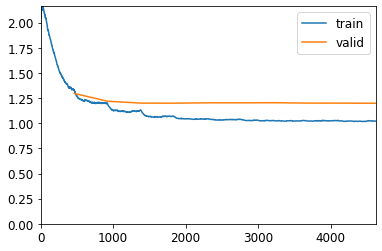

In [29]:
my_model14 = DotProductBias(n_users, n_items, n_factors, y_range=(0,4.5))
learn_wd14 = MyLearner(dls14, my_model14, loss_func=MSELossFlat(), opt_func=Adam, lr=5e-3, cbs=[ShowGraphCallback()], wd=1e-2, sim_lambda=1., l1_lambda=0., l2_lambda=0., decouple_wd=True) # wd, Adam
# Use sgd optimizer use following line
# learn_sgd14 = MyLearner(dls14, my_model14, loss_func=MSELossFlat(), opt_func=SGD, lr=1e-2, cbs=[ShowGraphCallback()], wd=0., sim_lambda=1., l1_lambda=5e-3, l2_lambda=5e-3, decouple_wd=False) # sgd
learn_wd14.fit(10)

## Get test result

In [30]:
def get_test_result(test_df, preds, ROUND=True):
  rows = []
  for idx, (user, item, actual_rate, pred_rate) in enumerate(sorted(zip(test_df.pipelines, test_df.instanceIDs, test_df.predictions, preds), reverse=True)):
    pred = round(float(preds[idx])) if ROUND else float(preds[idx])
    rows.append(dict({'user': test_df.pipelines.iloc[idx], 'item': test_df.instanceIDs.iloc[idx], 'actual_y': test_df.predictions.iloc[idx], 'pred_y': pred}))
  return pd.DataFrame(rows)

## My model test

#### Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}

In [31]:
test_dls01 = dls01.test_dl(test_df01)
preds01, labels01 = learn_wd01.get_preds(dl=test_dls01)

test_result01 = get_test_result(test_df01, preds01, ROUND=True)
accuracy = test_result01[np.isclose(test_result01.actual_y, test_result01.pred_y)].shape[0] / test_result01.actual_y.shape[0]
print('Acc: ', accuracy)
test_result01.head()

Acc:  0.931110029211295


,user,item,actual_y,pred_y
0,"[('lightGBM', LGBMClassifier(boosting_type='dart', colsample_bytree=0.7777777777777778,\n learning_rate=0.01634874872255883, min_child_samples=275,\n num_leaves=26, random_state=42, reg_alpha=0.5714285714285714,\n silent='warn', subsample=0.7676767676767677,\n subsample_for_bin=140000))]",863,0,0
1,"[('gaussiannb', GaussianNB())]",59,0,0
2,"[('adaboostclassifier', AdaBoostClassifier(learning_rate=0.5, n_estimators=100, random_state=42))]",1033,0,0
3,"[('quadraticdiscriminantanalysis', QuadraticDiscriminantAnalysis())]",309,0,0
4,"[('bernoullinb', BernoulliNB(binarize=0.75, fit_prior=False))]",615,1,1


#### Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive} 

In [32]:
test_dls14 = dls14.test_dl(test_df14)
preds14, labels14 = learn_wd14.get_preds(dl=test_dls14)

test_result14 = get_test_result(test_df14, preds14, ROUND=True)
pred, act = test_result14.pred_y, test_result14.actual_y
error_rates = np.absolute(np.divide(pred-act, act))
mean_acc = 1 - error_rates.mean()
print('Acc: ', float(mean_acc))
test_result14.head()

Acc:  0.8953870496592016


,user,item,actual_y,pred_y
0,"[('passiveaggressiveclassifier', PassiveAggressiveClassifier(C=0.001, loss='squared_hinge', random_state=42))]",740,1.0,1
1,"[('extratreesclassifier', ExtraTreesClassifier(bootstrap=True, max_features=None, min_samples_leaf=15,\n min_samples_split=10, n_estimators=500, random_state=42))]",1175,2.0,3
2,"[('svc', SVC(C=100.0, coef0=100.0, gamma='auto', probability=True, random_state=42))]",774,1.0,3
3,"[('quadraticdiscriminantanalysis', QuadraticDiscriminantAnalysis())]",1297,3.0,3
4,"[('baggingclassifier', BaggingClassifier(max_samples=0.6, random_state=42))]",1150,3.0,1


# Result Analysis: Factors Histogram

#### Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}
Plot the Histogram of **user_factors** (pipeline_factors) and **item_factors** (instance_factors)

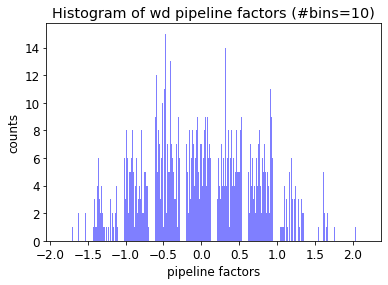

In [34]:
# (wd) pipeline_factors Histogram
x = learn_wd01.model.user_factors.detach().numpy()
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('pipeline factors')
plt.ylabel('counts')
plt.title('Histogram of wd pipeline factors (#bins=10)')
plt.show()

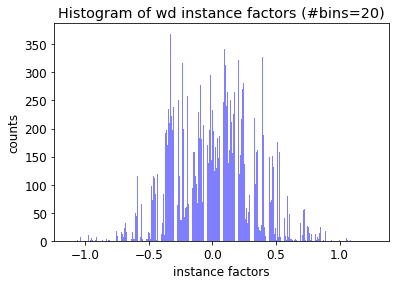

In [35]:
# (wd) instance_factors Histogram
x = learn_wd01.model.item_factors.detach().numpy()
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

# add a 'best fit' line
plt.xlabel('instance factors')
plt.ylabel('counts')
plt.title('Histogram of wd instance factors (#bins=20)')
plt.show()

#### Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive} 
Plot the Histogram of **user_factors** (pipeline_factors) and **item_factors** (instance_factors)

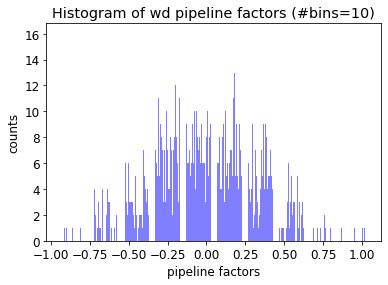

In [36]:
# (wd) pipeline_factors Histogram
x = learn_wd14.model.user_factors.detach().numpy()
num_bins = 10
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

plt.xlabel('pipeline factors')
plt.ylabel('counts')
plt.title('Histogram of wd pipeline factors (#bins=10)')
plt.show()

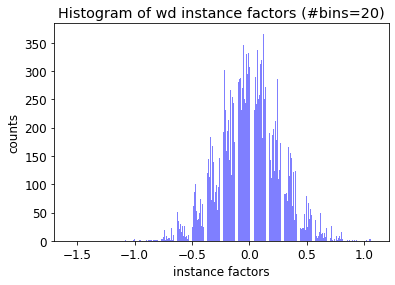

In [37]:
# (wd) instance_factors Histogram
x = learn_wd14.model.item_factors.detach().numpy()
num_bins = 20
# the histogram of the data
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)

# add a 'best fit' line
plt.xlabel('instance factors')
plt.ylabel('counts')
plt.title('Histogram of wd instance factors (#bins=20)')
plt.show()

# Result Analysis: Data Clustering

#### Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}

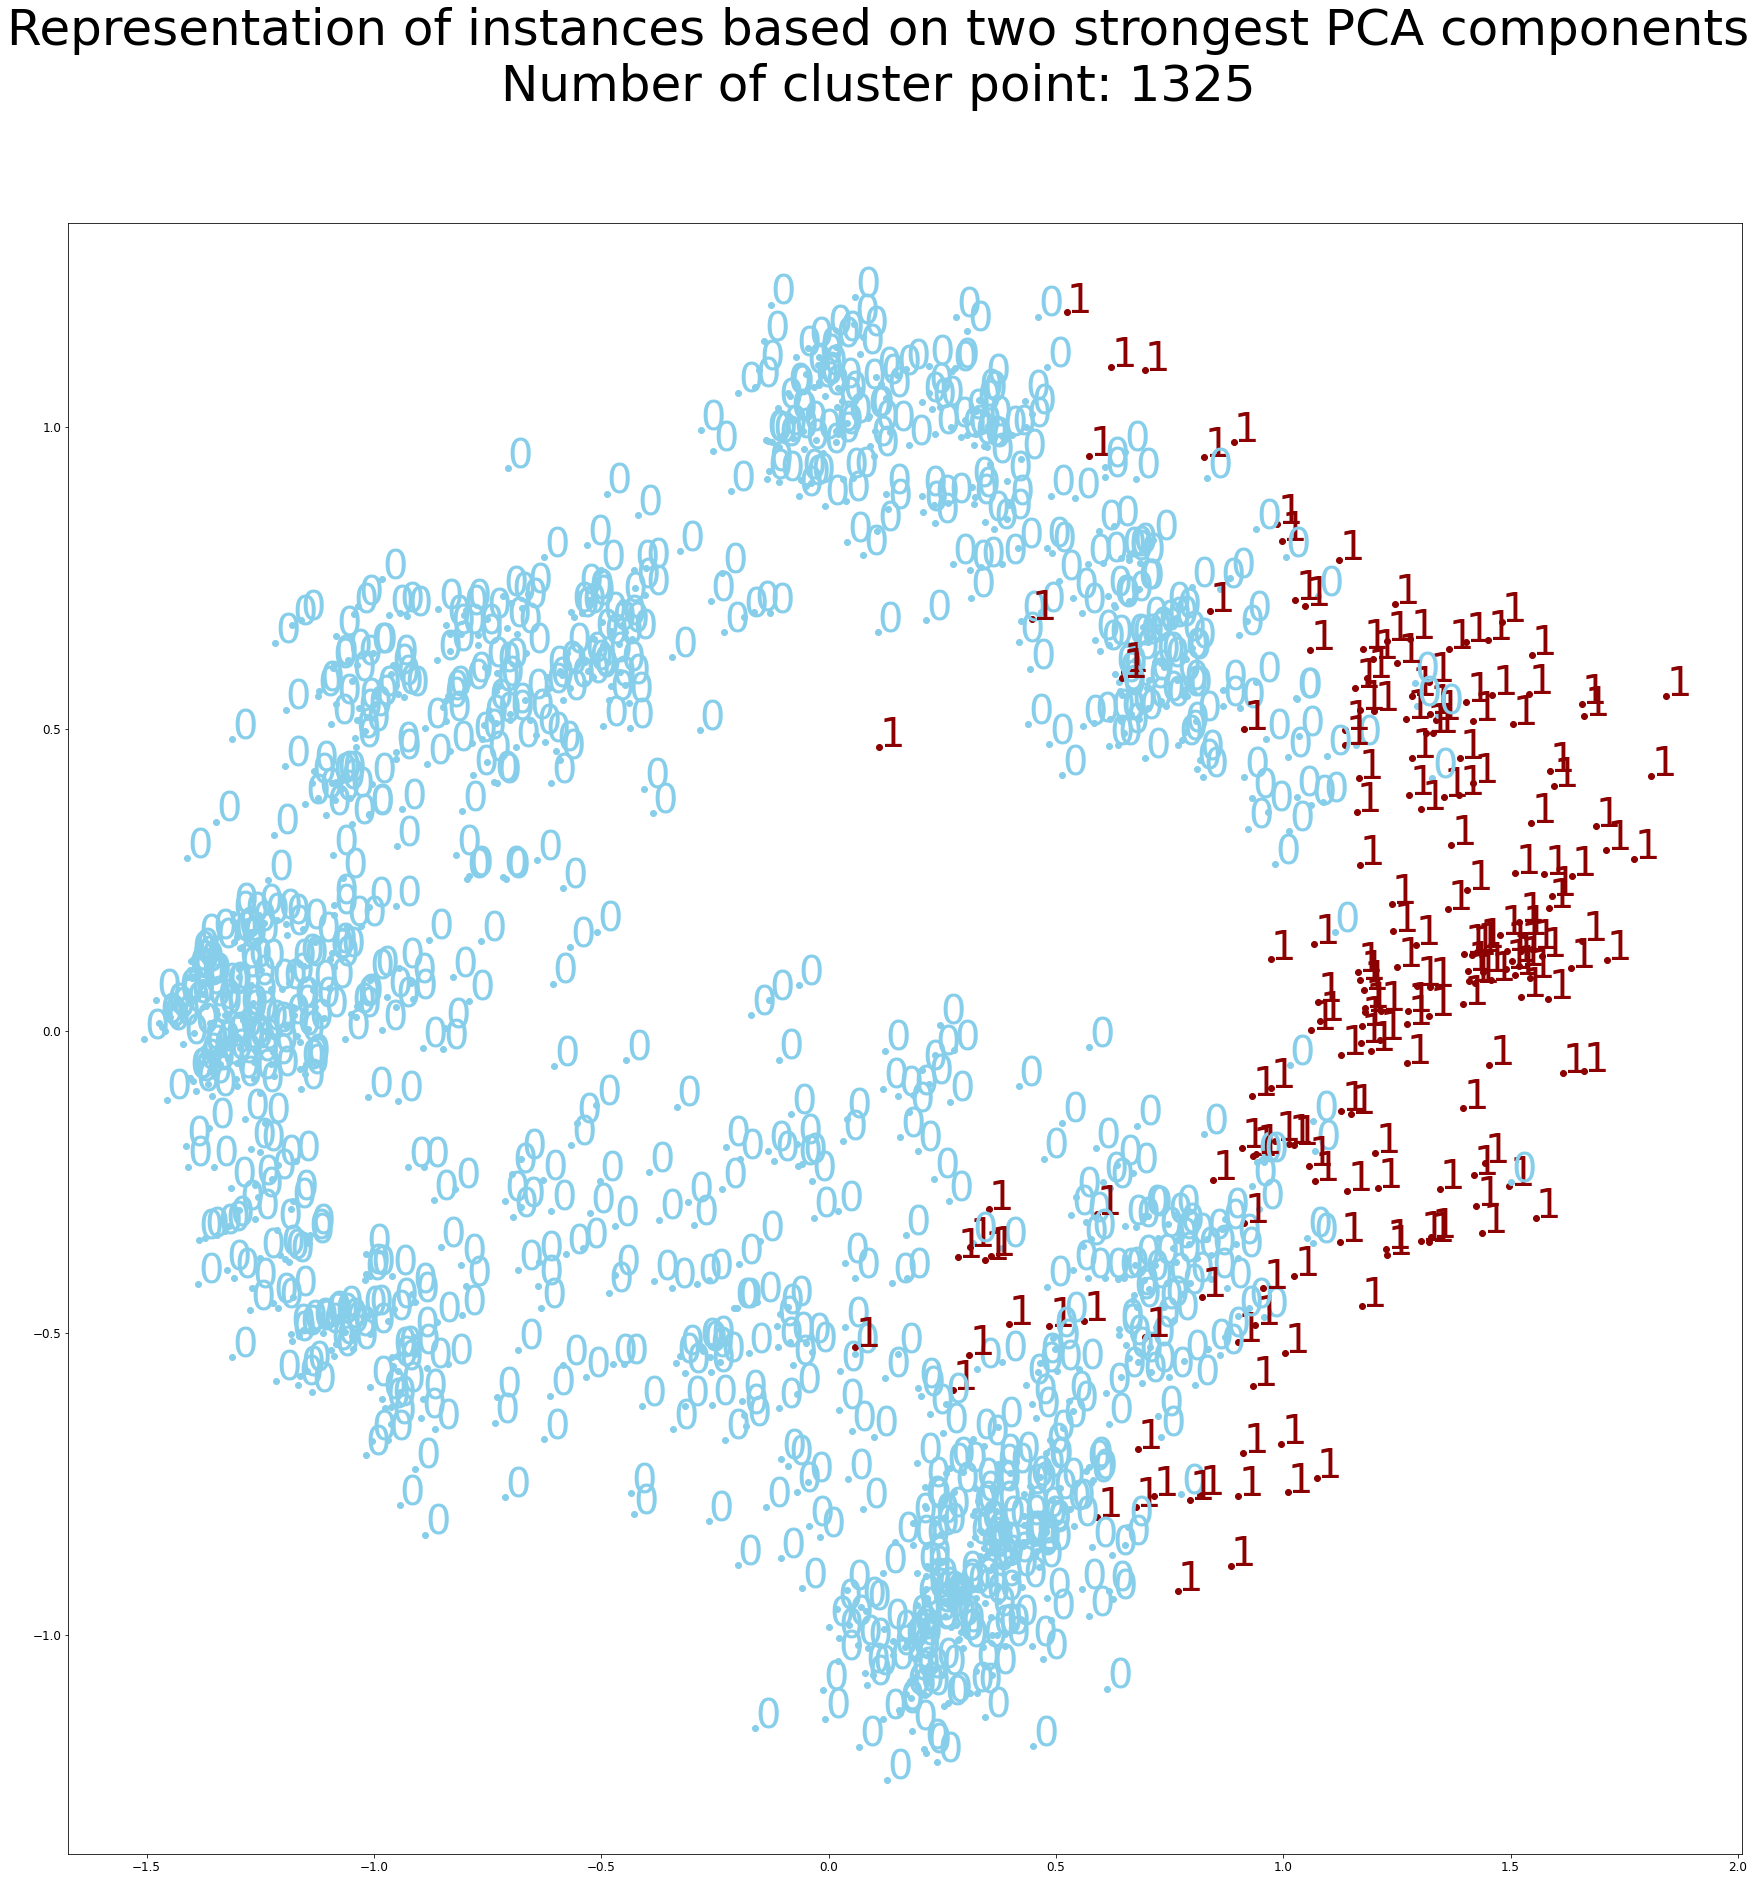

In [48]:
learn = learn_wd01

g = train_df01.groupby('instanceIDs')['predictions'].count()
pred_g = train_df01.groupby('instanceIDs').mean() 
pred_dict = pred_g.to_dict('dict')['predictions']

all_instances = g.sort_values(ascending=False).index.values[:train_df01.shape[0]]
all_idxs = tensor([learn.dls.classes['instanceIDs'].o2i[m] for m in all_instances])
instance_w = learn.model.item_factors[all_idxs].cpu().detach()
instance_pca = instance_w.pca(3)
fac0,fac1,fac2 = instance_pca.t()
idxs = list(range(all_instances.shape[0])) # plot all instances

LABEL_COLOR_MAP = {0: 'skyblue', 1 : 'darkred'}
X = fac0[idxs]
Y = fac1[idxs]
fig = plt.figure(figsize=(30,30))

cluster_point = 0
for i, x, y in zip(all_instances[idxs], X, Y):
  plt.scatter(x,y,c=LABEL_COLOR_MAP[round(pred_dict[i])])
  plt.text(x,y, str(round(pred_dict[i])), color=LABEL_COLOR_MAP[round(pred_dict[i])], fontsize=40)
  cluster_point += 1

plt.suptitle('Representation of instances based on two strongest PCA components' + '\n' + 'Number of cluster point: ' + str(cluster_point), fontsize=50)
plt.show()

#### Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive} 

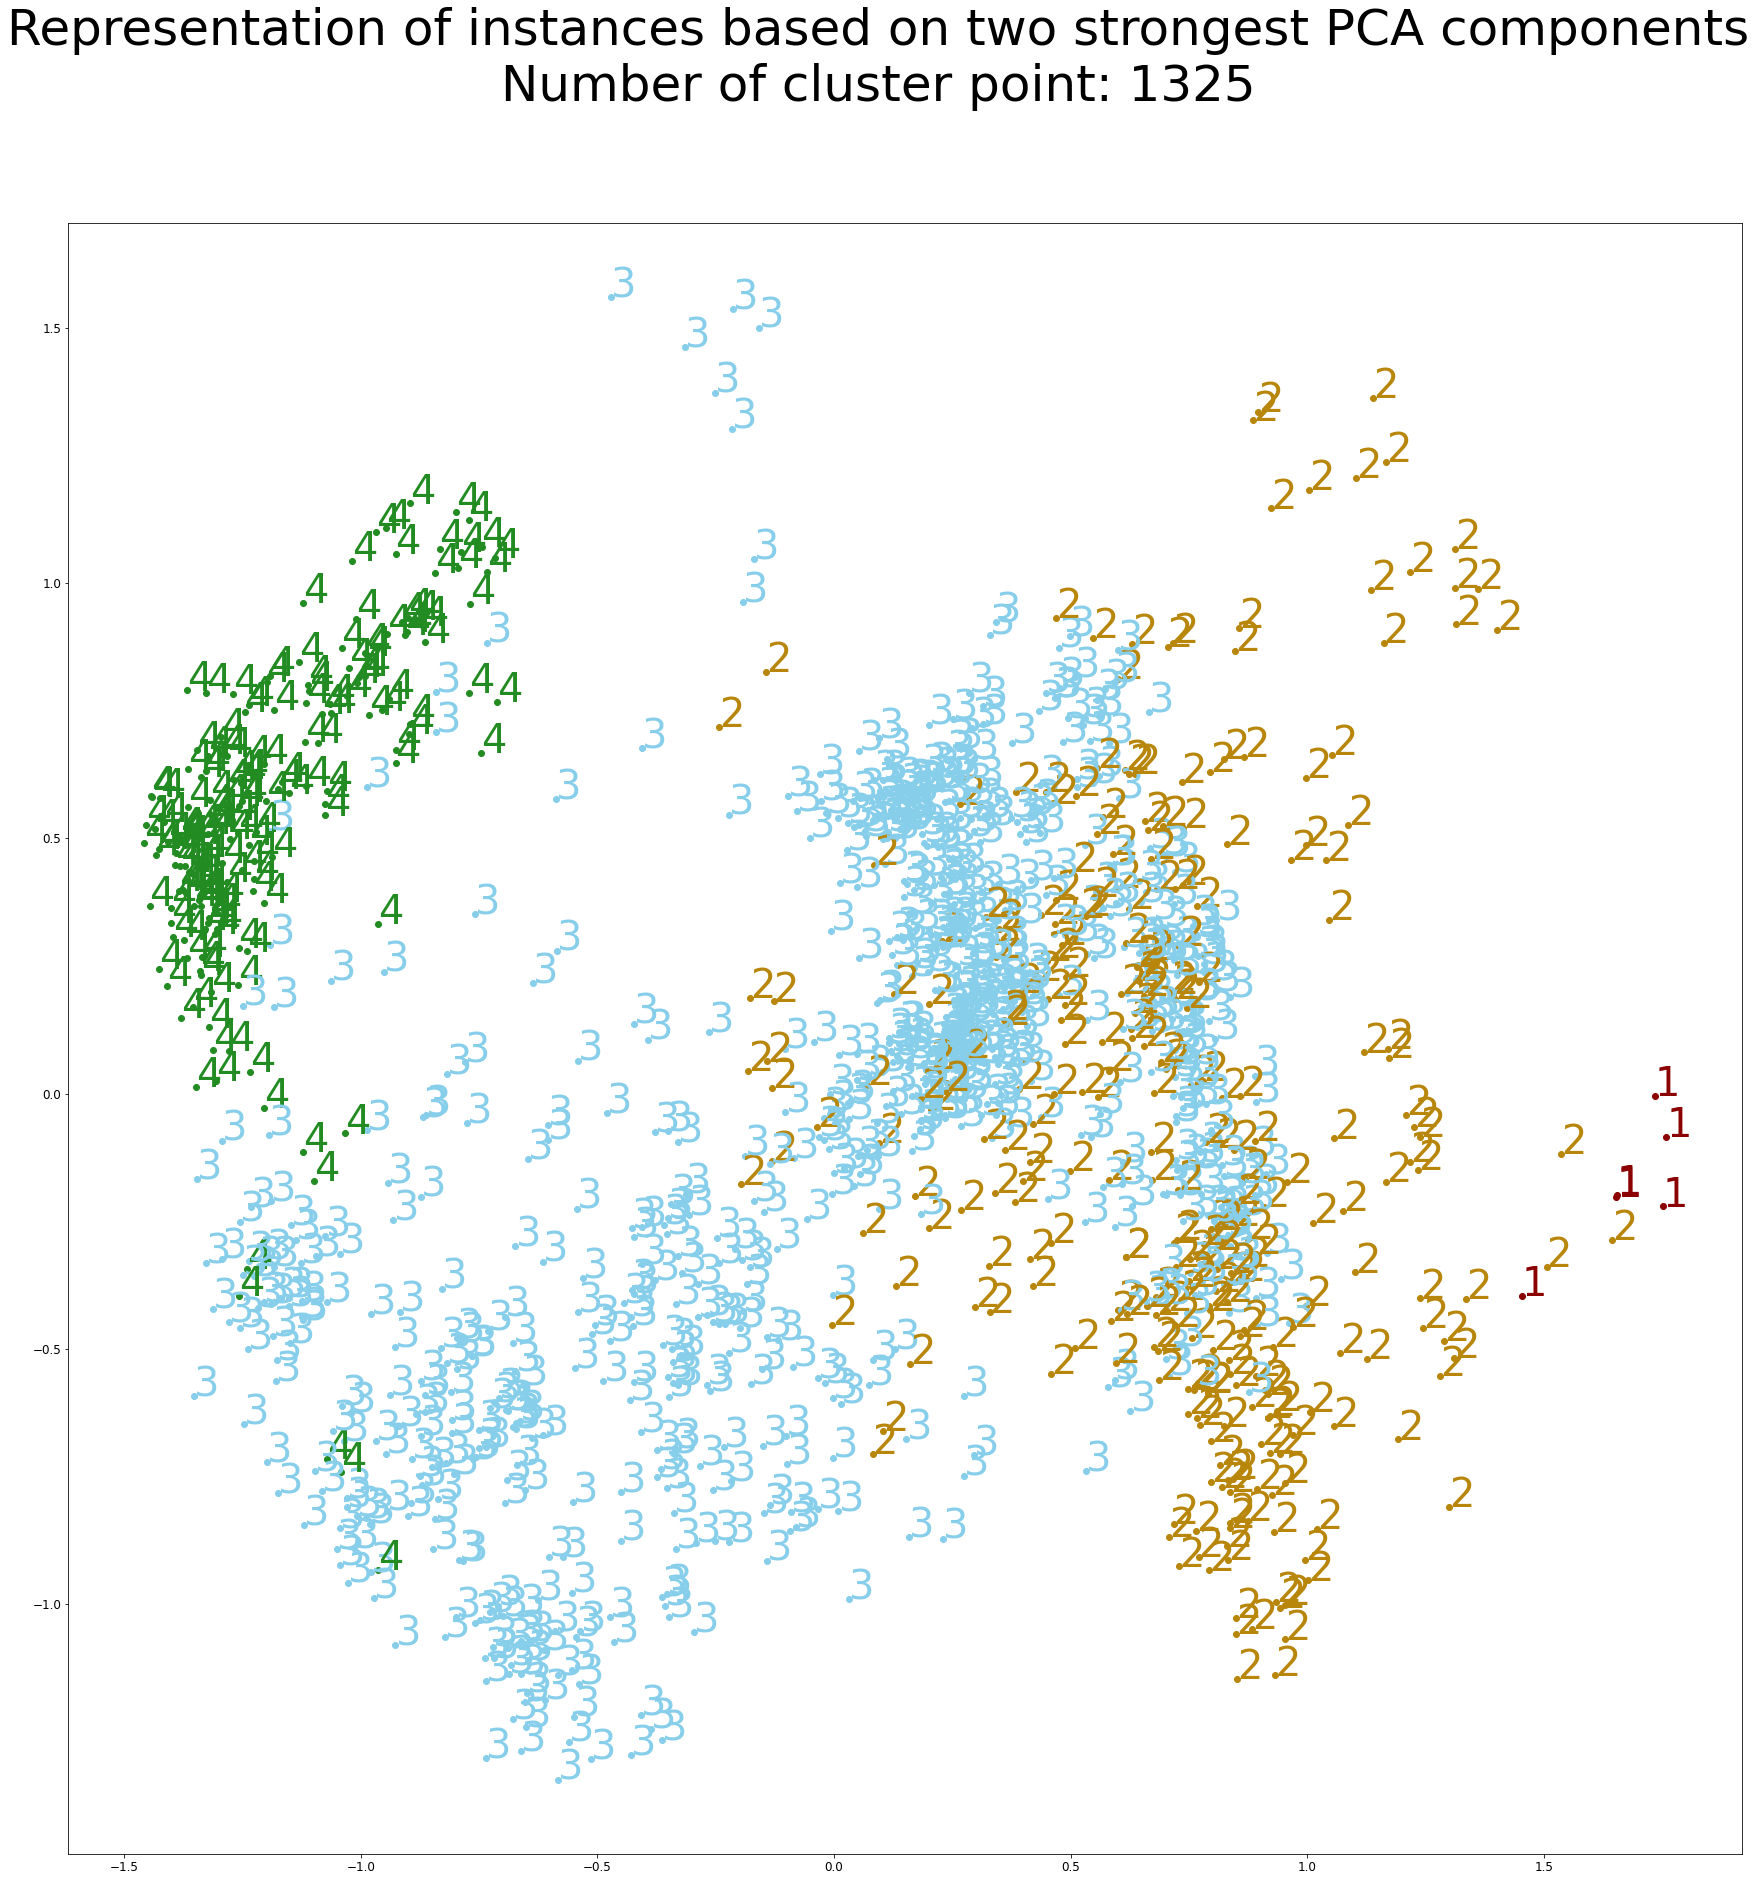

In [52]:
learn = learn_wd14

g = train_df14.groupby('instanceIDs')['predictions'].count()
pred_g = train_df14.groupby('instanceIDs').mean() 
pred_dict = pred_g.to_dict('dict')['predictions']

all_instances = g.sort_values(ascending=False).index.values[:train_df14.shape[0]]
all_idxs = tensor([learn.dls.classes['instanceIDs'].o2i[m] for m in all_instances])
instance_w = learn.model.item_factors[all_idxs].cpu().detach()
instance_pca = instance_w.pca(3)
fac0,fac1,fac2 = instance_pca.t()
idxs = list(range(all_instances.shape[0])) # plot all instances

LABEL_COLOR_MAP = {1 : 'darkred', 2 : 'darkgoldenrod', 3: 'skyblue', 4: 'forestgreen'}
X = fac0[idxs]
Y = fac1[idxs]
fig = plt.figure(figsize=(30,30))

cluster_point = 0
for i, x, y in zip(all_instances[idxs], X, Y):
  plt.scatter(x,y,c=LABEL_COLOR_MAP[round(pred_dict[i])])
  plt.text(x,y, str(round(pred_dict[i])), color=LABEL_COLOR_MAP[round(pred_dict[i])], fontsize=40)
  cluster_point += 1

plt.suptitle('Representation of instances based on two strongest PCA components' + '\n' + 'Number of cluster point: ' + str(cluster_point), fontsize=50)
plt.show()

# Result Analysis: Data Clustering (x, y) = (instance_bias, predictions)

#### Case 1 (01): prediction = {0, 1} = {True prediction, False prediction}

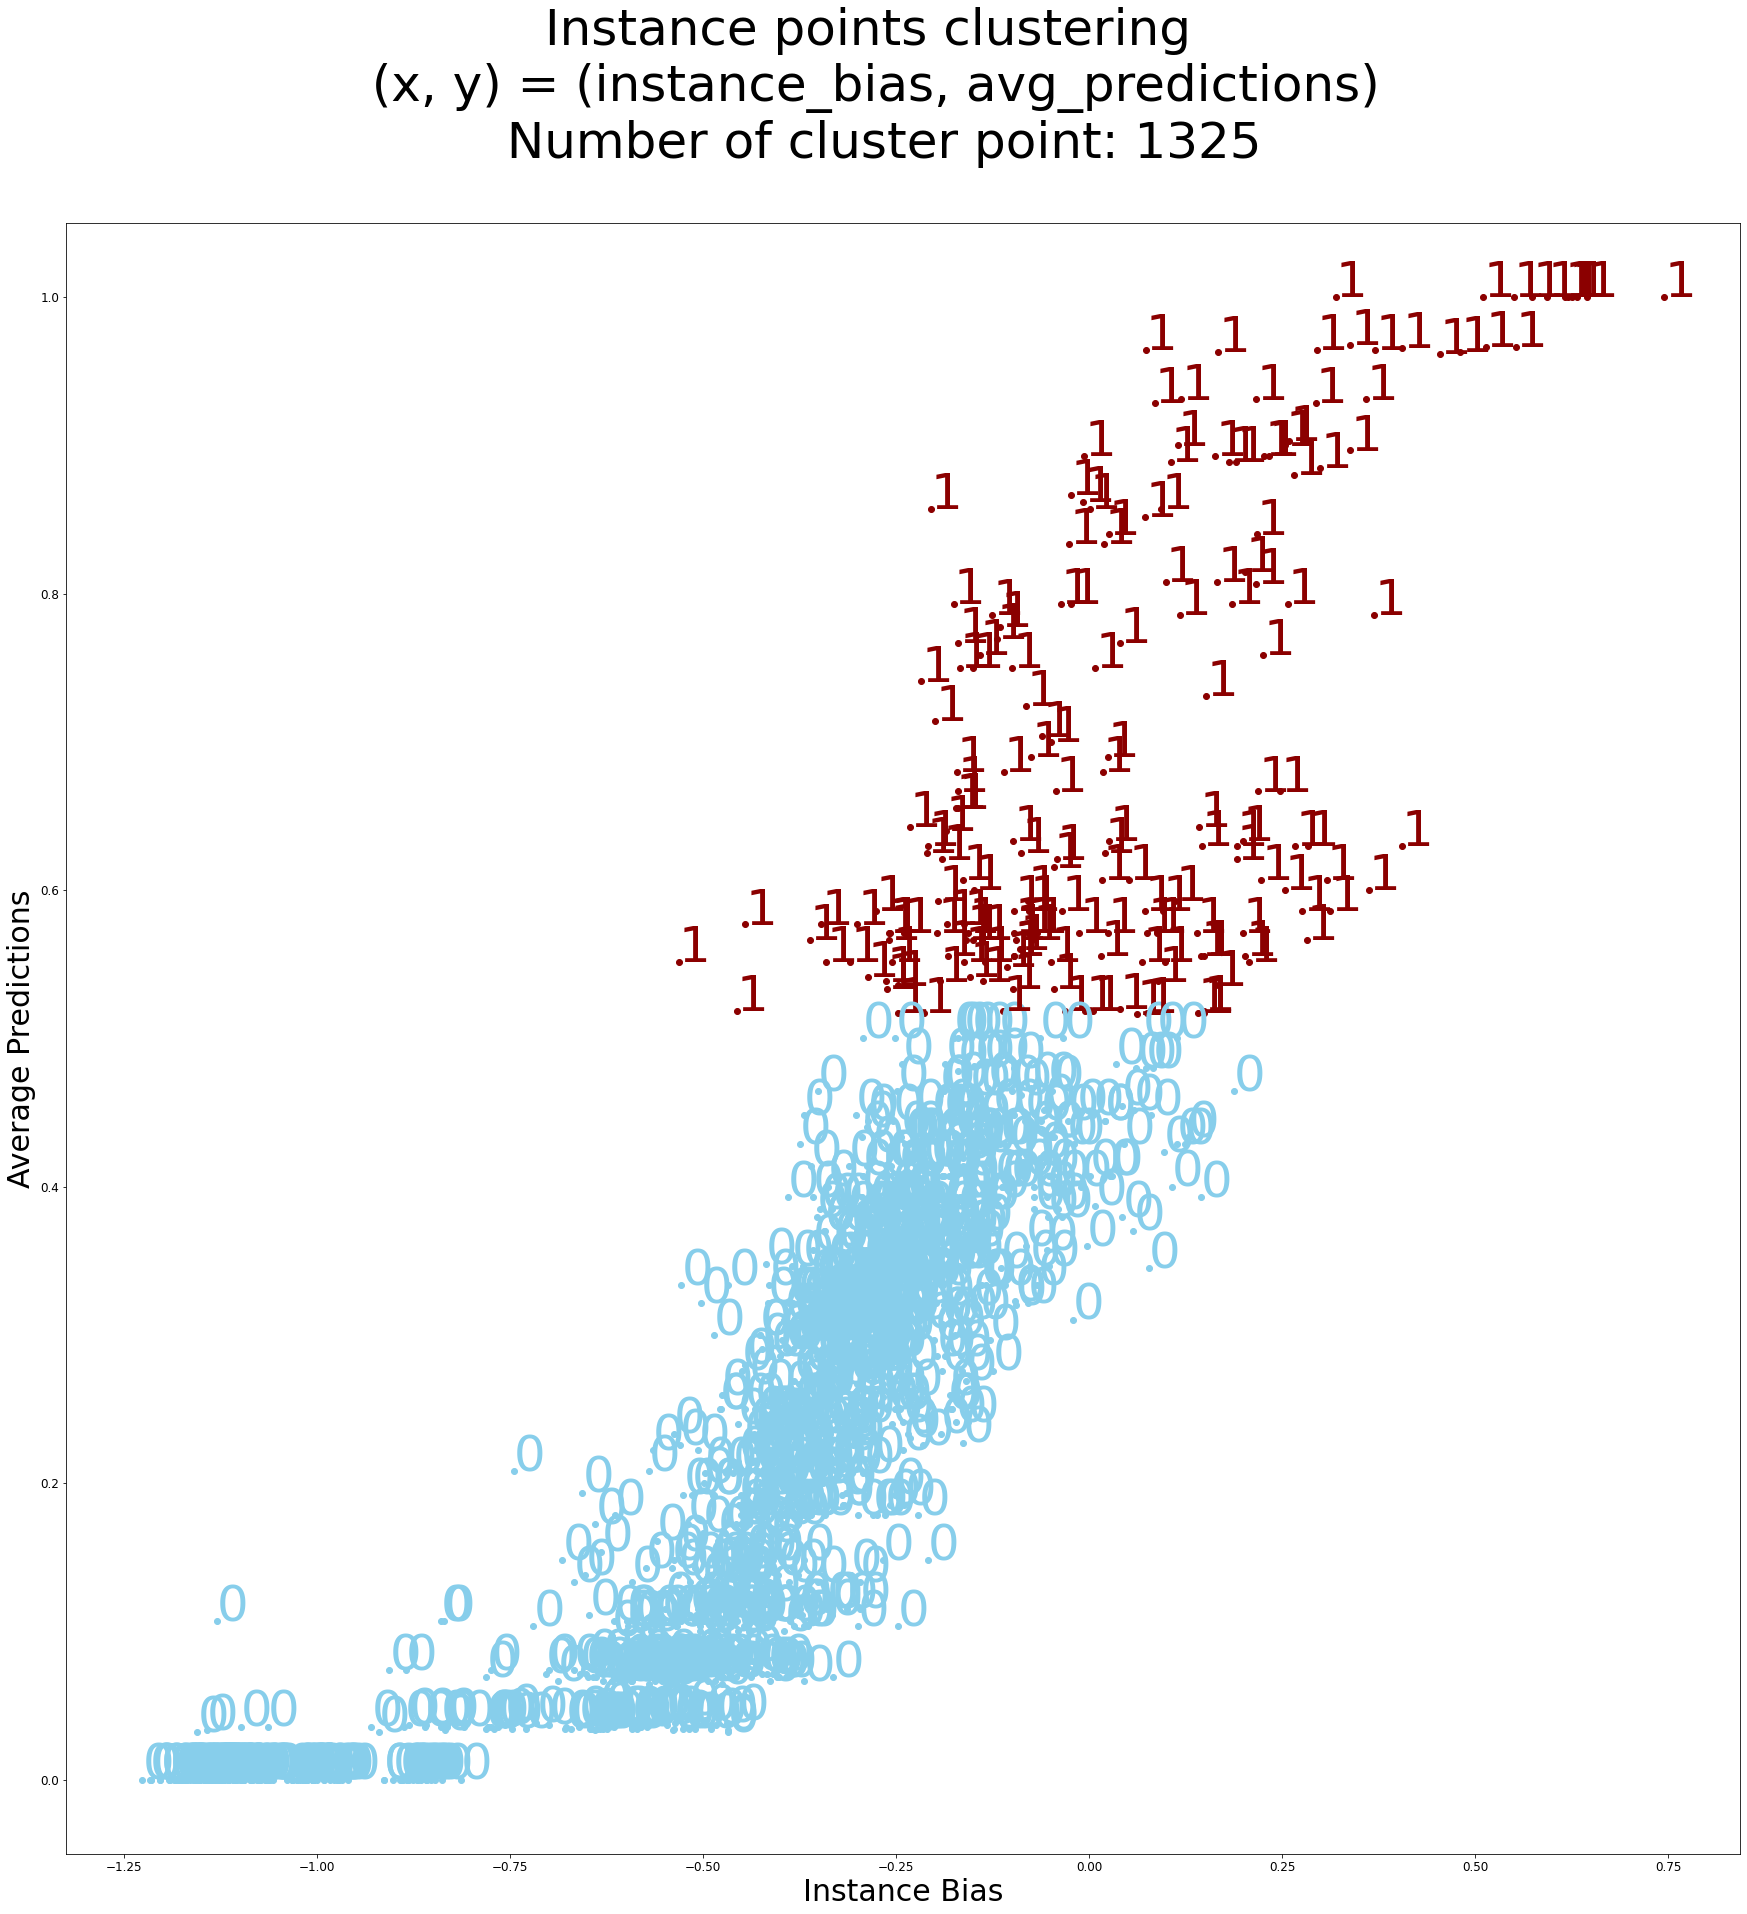

In [51]:
learn = learn_wd01

g = train_df01.groupby('instanceIDs')['predictions'].count()
pred_g = train_df01.groupby('instanceIDs').mean() 
pred_dict = pred_g.to_dict('dict')['predictions']

all_instances = g.sort_values(ascending=False).index.values[:train_df01.shape[0]]
all_idxs = tensor([learn.dls.classes['instanceIDs'].o2i[m] for m in all_instances])
instance_b = learn.model.item_bias[all_idxs].cpu().detach()

pred_tensor = []
for inst in all_instances:
  pred_tensor.append(pred_dict[inst])
pred_tensor =  torch.Tensor(pred_tensor)
idxs = list(range(all_instances.shape[0])) # all instances

LABEL_COLOR_MAP = {0: 'skyblue', 1 : 'darkred'}
X = instance_b[idxs]
Y = pred_tensor[idxs]

fig = plt.figure(figsize=(30,30))
plt.xlabel('Instance Bias', fontsize=30)
plt.ylabel('Average Predictions', fontsize=30)

cluster_point = 0
for i, x, y in zip(all_instances[idxs], X, Y):
  plt.scatter(x,y,c=LABEL_COLOR_MAP[round(pred_dict[i])])
  plt.text(x,y, str(round(pred_dict[i])), color=LABEL_COLOR_MAP[round(pred_dict[i])], fontsize=50)
  cluster_point += 1

fig.suptitle('Instance points clustering \n (x, y) = (instance_bias, avg_predictions) \n Number of cluster point: ' + str(cluster_point), fontsize=50)
plt.show()

#### Case 2 (14): prediction = {1, 2, 3, 4} = {false positive, true negative, false negative, true positive} 

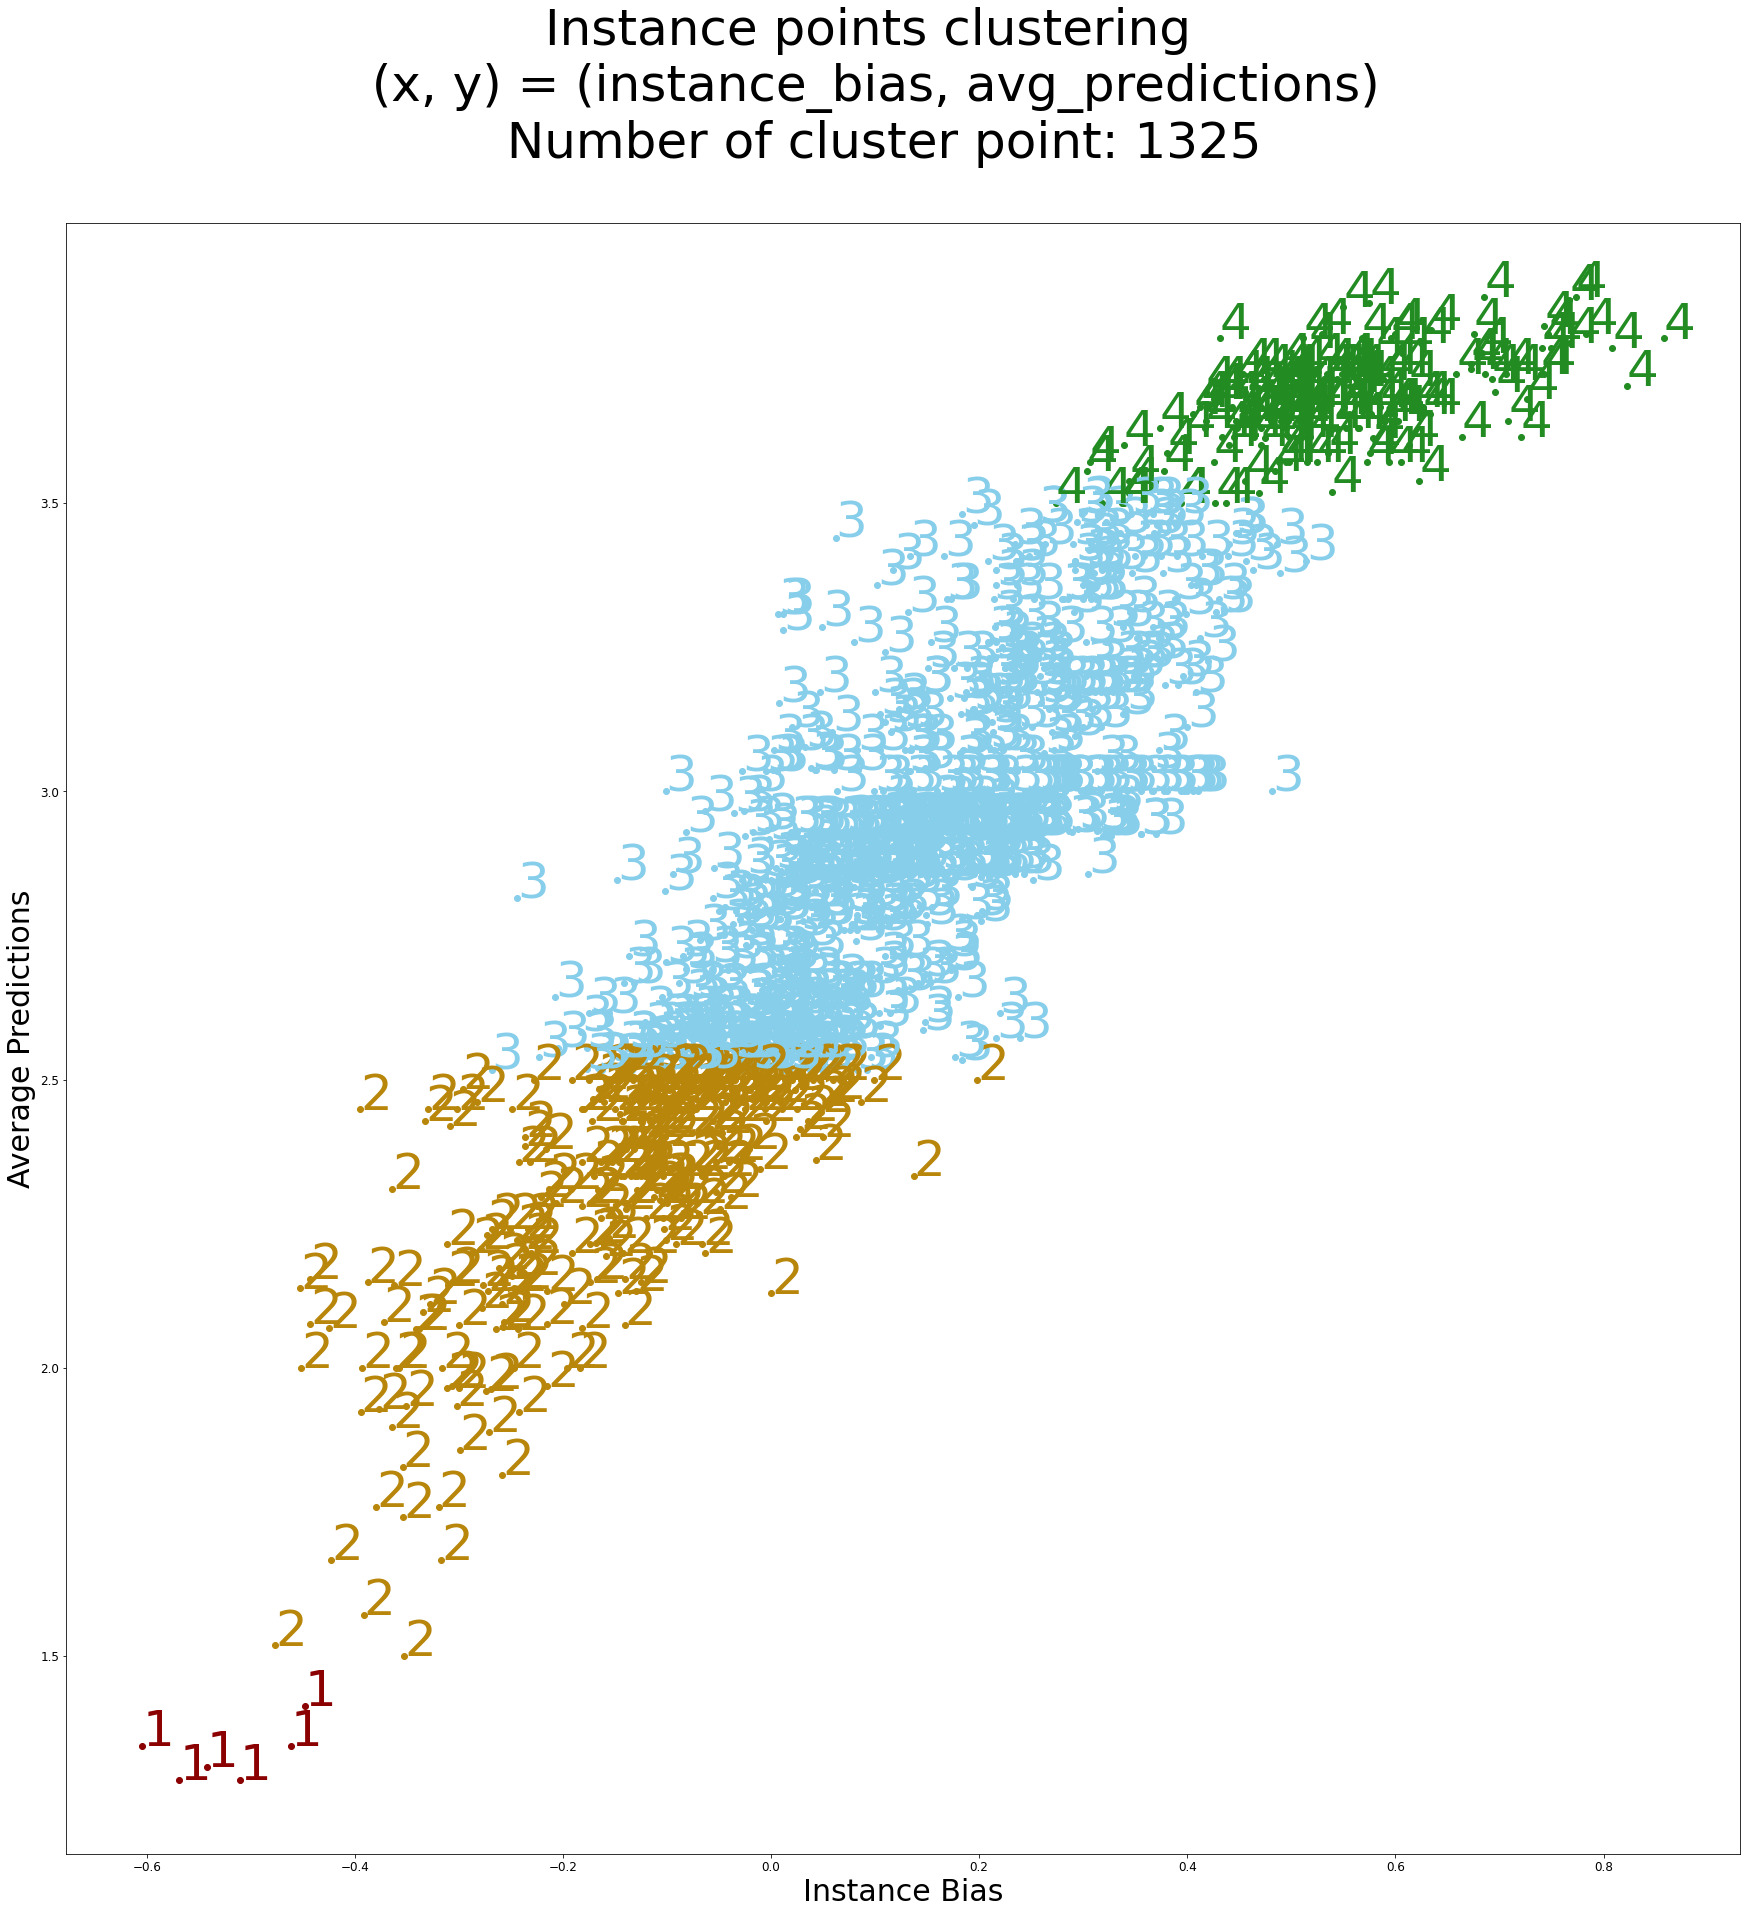

In [53]:
learn = learn_wd14

g = train_df14.groupby('instanceIDs')['predictions'].count()
pred_g = train_df14.groupby('instanceIDs').mean() 
pred_dict = pred_g.to_dict('dict')['predictions']

all_instances = g.sort_values(ascending=False).index.values[:train_df14.shape[0]]
all_idxs = tensor([learn.dls.classes['instanceIDs'].o2i[m] for m in all_instances])
instance_b = learn.model.item_bias[all_idxs].cpu().detach()

pred_tensor = []
for inst in all_instances:
  pred_tensor.append(pred_dict[inst])
pred_tensor =  torch.Tensor(pred_tensor)
idxs = list(range(all_instances.shape[0])) # all instances

LABEL_COLOR_MAP = {1 : 'darkred', 2 : 'darkgoldenrod', 3: 'skyblue', 4: 'forestgreen'}
X = instance_b[idxs]
Y = pred_tensor[idxs]

fig = plt.figure(figsize=(30,30))
plt.xlabel('Instance Bias', fontsize=30)
plt.ylabel('Average Predictions', fontsize=30)

cluster_point = 0
for i, x, y in zip(all_instances[idxs], X, Y):
  plt.scatter(x,y,c=LABEL_COLOR_MAP[round(pred_dict[i])])
  plt.text(x,y, str(round(pred_dict[i])), color=LABEL_COLOR_MAP[round(pred_dict[i])], fontsize=50)
  cluster_point += 1

fig.suptitle('Instance points clustering \n (x, y) = (instance_bias, avg_predictions) \n Number of cluster point: ' + str(cluster_point), fontsize=50)
plt.show()